In [11]:
import gsum as gs
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sp

%matplotlib inline

In [328]:
mpl.rcParams['figure.dpi'] = 120

In [443]:
def rbf(X, Xp=None, ls=1):
    if Xp is None:
        Xp = X
    diff = X[:, None, ...] - Xp[None, ...]
    dist = np.linalg.norm(diff, axis=-1)
    if ls == 0:
        return np.where(dist == 0, 1., 0.)
    return np.exp(- 0.5 * dist**2 / ls**2)

def d_rbf(X, Xp=None, ls=1):
    if Xp is None:
        Xp = X
    diff = X[:, None, ...] - Xp[None, ...]
    # dist = np.linalg.norm(diff, axis=-1)
    dist = X - Xp.T
    return -1 / ls**2 * dist * rbf(X, Xp, ls)

def d2_rbf(X, Xp=None, ls=1):
    if Xp is None:
        Xp = X
    dist = (X - Xp.T)
    dist = dist * dist
    I = 1.
    return 1. / ls**2 * (I - dist / ls**2) * rbf(X, Xp, ls)

def all_rbf(X, Xp=None, ls=1):
    K = rbf(X, Xp, ls)
    Kp = d_rbf(X, Xp, ls)
    Kpp = d2_rbf(X, Xp, ls)
    return np.block([[K, -Kp.T], [Kp, Kpp]])

def deriv_mean(Xnew, X, y, ls=1):
    Kn = rbf(Xnew, X, ls)
    K = rbf(X, X, ls)
    alpha = np.linalg.solve(K, y)
    return - 1./ls**2 * np.diag((Xnew - X.T) @ (Kn * alpha).T)
    
def deriv_kernel(Xnew, X, ls=1):
    K = rbf(X, X, ls)
    Kp = d_rbf(Xnew, X, ls)
    Kpp = d2_rbf(Xnew, Xnew, ls)
    return Kpp - Kp @ np.linalg.solve(K, -Kp.T)


def rbf_flex(X, Xp, d=None, dp=None, ls=1.):
    n = len(X)
    if d is None:
        d = np.zeros(n)
    if dp is None:
        dp = d
    if Xp is None:
        Xp = X
    K = rbf(X[d==0], Xp[d==0], ls=ls)
    derivs = np.sum(d+dp) > 0
    if derivs:
        Kp = d_rbf(X[d==1], Xp[d==0], ls=ls)
        Kpp = d2_rbf(X[d==1], Xp[d==1], ls=ls)
        K = np.block([[K, -Kp.T], [Kp, Kpp]])
    return K

def conditional_kernel(K):
    return

In [467]:
n = 7
n_new = 60
x = np.linspace(0, 2*np.pi, n)
X = x[:, None]

x_new = np.linspace(0, 2*np.pi, n_new)
X_new = x_new[:, None]
noise = 1e-6
ls = 1*np.pi
# K_all = all_rbf(X, X, ls)
K = rbf(X, X, ls)
d2K = d2_rbf(X, X, ls)
# K = rbf(X, X, ls)
K += noise**2 * np.eye(K.shape[-1])
d2K += noise**2 * np.eye(K.shape[-1])
K_all += noise**2 * np.eye(K_all.shape[-1])

# print(np.allclose(K.T, K))
# print(sp.linalg.eigvalsh(K))
# print(np.allclose(d2K.T, d2K))
# print(sp.linalg.eigvalsh(d2K))
# print(sp.linalg.eigvalsh(K_all))
# print(K)
np.random.seed(4)
# mvn = sp.stats.multivariate_normal(cov=np.eye(n))
# Z = mvn.rvs()
# L = np.linalg.cholesky(K)
# d2L = np.linalg.cholesky(d2K)

# y = L @ Z
y = np.sin(x)
# yp = d2L @ Z

yp = deriv_mean(X_new, X, y, ls=ls)
K_dv = deriv_kernel(X_new, X, ls=ls)
sd_dv = np.sqrt(np.diag(K_dv))

yp_approx = np.gradient(y, x)

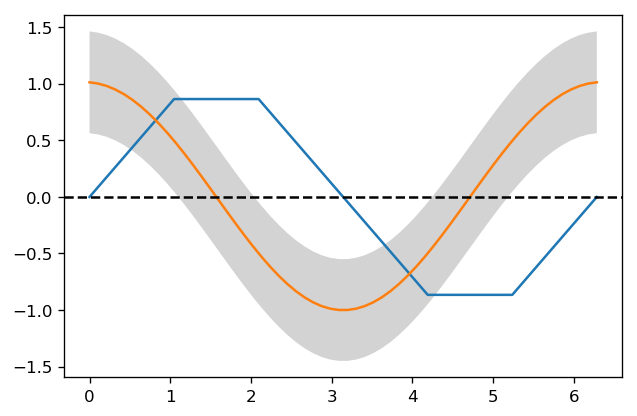

In [468]:
plt.plot(x, y)
plt.plot(x_new, yp)
plt.fill_between(x_new, yp+sd_dv, yp-sd_dv, facecolor='lightgrey')
# plt.plot(x, yp_approx, ls='--')
plt.axhline(0, 0, 1, c='k', ls='--');

In [205]:
nn = 10
ni = np.concatenate((np.zeros(nn), np.ones(nn)))[:, None]
nj = ni
l_mat = np.array([[ls]])
xx = np.linspace(0, 1, nn)
Xi = np.concatenate((xx, xx))[:, None]
Xj = Xi
tau = Xi - Xj
n_tot_j = sp.asarray(sp.sum(nj, axis=1), dtype=int).flatten()
n_combined = sp.asarray(ni + nj, dtype=int)
# Compute factor from the dtau_d/dx_d_j terms in the chain rule:
j_chain_factors = (-1.0)**(n_tot_j)
# Compute Hermite polynomial factor:
hermite_factors = (
    (-1.0 / (l_mat))**(n_combined) *
    sp.special.eval_hermite(n_combined, tau / (l_mat))
)
# print(Xi[:2], hermite_factors.shape)
K = rbf(Xi, Xj, ls=ls)
# print(K)
K = j_chain_factors * sp.prod(hermite_factors, axis=1) * K
myK = all_rbf(Xi[:nn], Xj[:nn], ls)

In [470]:
factors = (
    (-1.0 / (l_mat))**(n_combined) *
    sp.special.eval_hermite(n_combined, tau / (l_mat))
)
hermite_factors

array([[  1.],
       [  1.],
       [  1.],
       [  1.],
       [  1.],
       [  1.],
       [  1.],
       [  1.],
       [  1.],
       [  1.],
       [-50.],
       [-50.],
       [-50.],
       [-50.],
       [-50.],
       [-50.],
       [-50.],
       [-50.],
       [-50.],
       [-50.]])

In [471]:
n_tot_j

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [490]:
herm = sp.special.eval_hermite(np.random.randint(0, 10, (3, 7, 7)), np.random.rand(7, 7))

In [491]:
herm.shape

(3, 7, 7)

In [488]:
herm

array([[ 5.53951832e+03,  1.00000000e+00,  1.85953113e+02],
       [-2.08726070e+03,  4.10851699e+01, -1.24933951e+02],
       [-3.27612966e+00, -2.20565056e+03,  1.90791195e+00],
       [ 1.52608762e+00, -4.88666222e+00,  1.00000000e+00],
       [ 2.06571939e+01,  3.95982342e+01,  1.77018470e+02],
       [ 6.89795298e+01,  1.00000000e+00,  3.56520336e+03],
       [ 2.58498564e+01,  1.46876398e+01, -2.70315021e+00]])